<a href="https://colab.research.google.com/github/LucianaNieto/preliminary_exam/blob/main/220916_Nieto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries, install and import

In [ ]:
#install libraries 
%%capture 
#!pip install folium
!pip install pyecharts
!pip install plotly==5.10.0
!pip install jupyter-dash
!pip install -U kaleido
!pip install gensim
!pip install fasttext
!pip install pdfminer.six
!pip install pyLDAvis

In [ ]:
# Import other libraries
%%capture 
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
#import folium
#from folium import plugins
from pyecharts import options as opts
from pyecharts.charts import Map3D
from pyecharts.globals import ChartType
from pyecharts.commons.utils import JsCode
import plotly.express as px
from plotly import graph_objects as go
import re
import nltk
nltk.download('wordnet','stopwords') 
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter 
from wordcloud import WordCloud

from pdfminer.high_level import extract_text
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models import FastText
from gensim.test.utils import get_tmpfile
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
import io
import fasttext
import string
import pyLDAvis
import pyLDAvis.gensim_models 
from pandas.core import window


## Article indentification, screening and retrieval, following the PRISMA 2020 flow diagram 

* number of records per database
* remove duplicates 
* filter based on JCR Quantile (Q1-Q3)
* full article reading and human removal, final document - filteredMT.csv



In [ ]:
#number of records per database: WoS= web of science, Scopus= Elsevier, GS= Google Scholar
WoS= pd.read_csv('/content/drive/My Drive/prelims/WoS.csv')
scopus=pd.read_csv('/content/drive/My Drive/prelims/scopus.csv')
GS=pd.read_csv('/content/drive/My Drive/prelims/GS.csv')
print(len(WoS))
print(len(scopus))
print(len(GS))
doc= WoS.append(scopus)
bibliography =doc.append(GS)
print(len(bibliography))

89
136
101
326


In [ ]:
bibliography.sort_values("Title");

In [ ]:
duplicates = pd.concat(d for _, d in bibliography.groupby("Title") if len(d) >1)

duplicates.sort_values("Title");

In [ ]:
bibliography_2=bibliography.drop_duplicates(subset=['Title'])
print(len(bibliography_2))
bibliography_2.to_csv("/content/drive/My Drive/prelims/bibliography_2.csv")

291


In [ ]:
JCR= pd.read_csv('/content/drive/My Drive/prelims/JCRlist2022_clean.csv') #JCR list with separated columns for each quantile, june 2022
doc= pd.read_csv('/content/drive/My Drive/prelims/clean_final.csv') #dataset after screening for records with abstracts (n=278, 13 records did not have abtract)

In [ ]:
#import journals names with quantile information, convert to dictionary 
dict_JCR=pd.read_csv('/content/drive/My Drive/prelims/JCRlist2022_clean.csv', header=None, index_col=0, squeeze=True).to_dict()
#print(dict_JCR)

In [ ]:
# map the information from the dictionary using the column with the journal names to create a new column w/t Q data 
doc['quantile']= doc['code'].map(dict_JCR)
doc.head(2)

,Authors,Author Full Names,Title,Source title,code,Language,Document Type,Author Keywords,Keywords Plus,Abstract,...,Index Keywords,Language of Original Document,Publication Stage,Open Access,Source,EID,Publication,Number,Pages,quantile
0,"Tripathi A., Tiwari R.K.",NaN,Utilisation of spaceborne C-band dual pol Sent...,Advances in Space Research,advances in space research,NaN,Article,OLS regression; RF regression; SAR backscatter...,NaN,Soil Organic Carbon (SOC) is a measure of the ...,...,Agriculture; Backscattering; Decision trees; M...,English,Final,NaN,Scopus,2-s2.0-85113859289,NaN,NaN,NaN,Q2
1,"Menefee, D; Rajan, N; Cui, S; Bagavathiannan, ...","Menefee, Dorothy; Rajan, Nithya; Cui, Song; Ba...",Carbon exchange of a dryland cotton field and ...,AGRICULTURAL AND FOREST METEOROLOGY,agricultural and forest meteorology,English,Article,Eddy covariance; Carbon sequestration; Cotton;...,DIOXIDE EXCHANGE; USE EFFICIENCY; WATER-USE; F...,Agricultural systems experience numerous manag...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q1


In [ ]:
#filter and check how many articles belong to each quantile 

doc_q1= doc.loc[(doc['quantile'] == 'Q1')]
print(len(doc_q1))

doc_q2= doc.loc[(doc['quantile'] == 'Q2')]
print(len(doc_q2))

doc_q3= doc.loc[(doc['quantile'] == 'Q3')]
print(len(doc_q3))

doc_q4= doc.loc[(doc['quantile'] == 'Q4')]
print(len(doc_q4))

doc['quantile'].isna().sum()

dfs= [doc_q1, doc_q2, doc_q3]

doc_q123 = pd.concat(dfs)

print(len(doc_q123))


doc_q123.to_csv("/content/drive/My Drive/prelims/docs.csv")#final doc with records matching only Q1-Q3 journals 

138
35
13
14
186


186 records were kept and moved to further screening, leaving only those that met the following criteriria: 
* had some sort of remote sensing data involved spaceborn, airborn or UAV)
* had measurements on soil carbon or biomass collected 
* had some relationship with agricultural lands
* only records after 2012 

This resulted on 56 articles. From these articles, 28 more documents were retrieved from the bibliography records that followed the same criteria outlined before. 

The next steps were conducted on 84 documents. 

## Figures and further analysis 


A table containing all the metadata from each document was created in order to analyze the relationships between each record and to capture the general trend among the bibliography. In addition, data retrieved from each manuscript was also added to the table, such as: 
* type of article (article or review) [type]
* spectral (multispectral or hyperspectral) [Spectral]
* type of remote sensing used (Space born, Airborn, UAV) [RS_type]
* Above ground or below ground measurements [AG_BG]
* Country or area where the analysis was conducted (Specific country, global, or multiple countries -more than two-) [Area_Country]
* Statistical methods used [Methods]
* Latitude and Longitude if country was specified [Latitude], [Longitude]

In [ ]:
docBiblio=pd.read_csv('/content/drive/My Drive/prelims/final_bibliography.csv')

In [ ]:
docBiblio.columns

Index(['Key', 'Item Type', 'Publication Year', 'Author', 'Title', 'type',
       'Spectral', 'RS_type', 'AG_BG', 'Method', 'Area_Country', 'Latitude',
       'Longitude', 'Publication Title', 'ISBN', 'ISSN', 'DOI', 'Url',
       'Abstract Note', 'Date', 'Date Added', 'Date Modified', 'Access Date',
       'Pages', 'Num Pages', 'Issue', 'Volume', 'Number Of Volumes',
       'Journal Abbreviation', 'Short Title', 'Series', 'Series Number',
       'Series Text', 'Series Title', 'Publisher', 'Place', 'Language',
       'Rights', 'Type', 'Archive', 'Archive Location', 'Library Catalog',
       'Call Number', 'Extra', 'Notes', 'File Attachments'],
      dtype='object')

In [ ]:

docBiblio.drop(['Item Type','Key', 'ISBN', 'ISSN', 'DOI',
                'Date', 'Date Added', 'Date Modified', 'Access Date',
                'Pages', 'Num Pages', 'Issue', 'Volume', 'Number Of Volumes',
                'Journal Abbreviation', 'Short Title', 'Series', 'Series Number',
                'Series Text', 'Series Title', 'Publisher', 'Place', 'Language',
                'Rights', 'Type', 'Archive', 'Archive Location', 'Library Catalog',
                'Call Number', 'Extra', 'Notes', 'File Attachments'], axis=1, inplace=True)


In [ ]:
docBiblio.columns

Index(['Publication Year', 'Author', 'Title', 'type', 'Spectral', 'RS_type',
       'AG_BG', 'Method', 'Area_Country', 'Latitude', 'Longitude',
       'Publication Title', 'Url', 'Abstract Note'],
      dtype='object')

In [ ]:
docBiblio.describe() #to check only documents after 2012 are part of the scopus 

,Publication Year,Latitude,Longitude
count,84.000000,60.000000,60.000000
mean,2017.988095,31.523009,16.487947
std,2.722039,22.966963,71.167332
min,2012.000000,-26.500000,-98.579500
25%,2016.000000,30.000000,-55.000000
50%,2018.000000,35.000000,12.833333
75%,2020.000000,46.937500,77.000000
max,2022.000000,60.000000,135.000000


In [ ]:
#docBiblio.groupby('Area_Country').count()

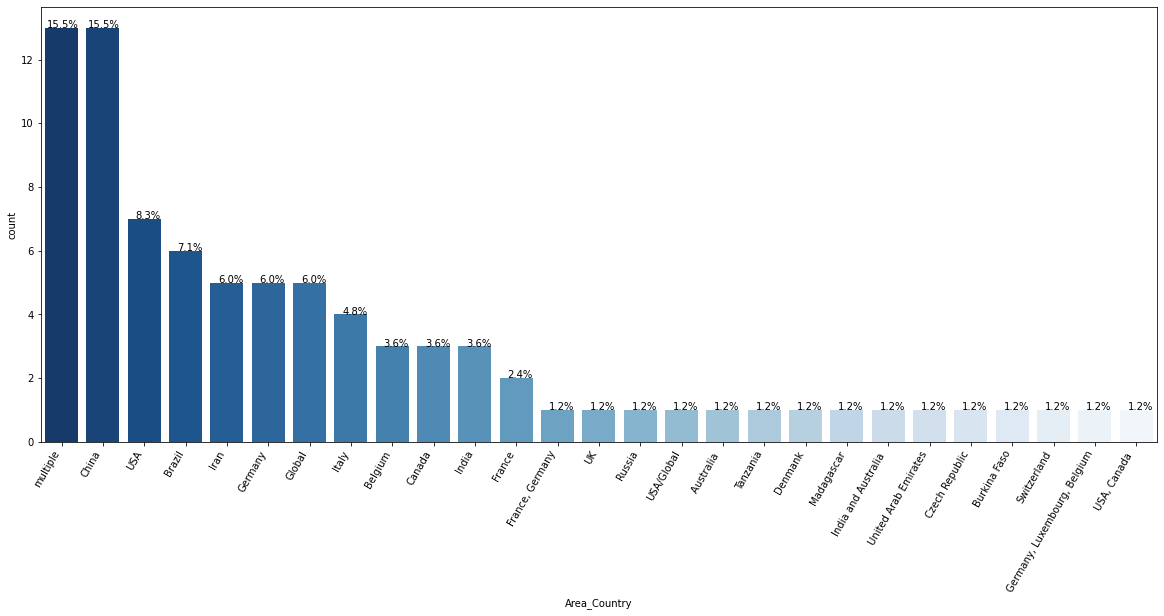

In [ ]:
total = float(len(docBiblio))
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(x='Area_Country', data=docBiblio, palette="Blues_r", order = docBiblio['Area_Country'].value_counts().index, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right')

plt.savefig('/content/drive/My Drive/prelims/figures/byCountry.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/byCountry.svg')

plt.show()

In [ ]:
#docBiblio.groupby('AG_BG').count()

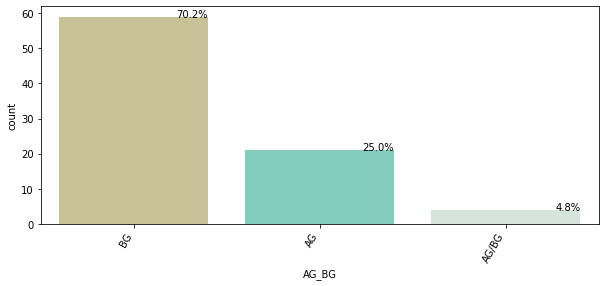

In [ ]:
total = float(len(docBiblio))

GB = ["#CFC98D","#76D7C4", "#D4E6DE" ]
sns.set_palette(GB)

fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x='AG_BG', data=docBiblio, order = docBiblio['AG_BG'].value_counts().index, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right')

plt.savefig('/content/drive/My Drive/prelims/figures/byAGBG.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/byAGBG.svg')

# Show the plot
plt.show()


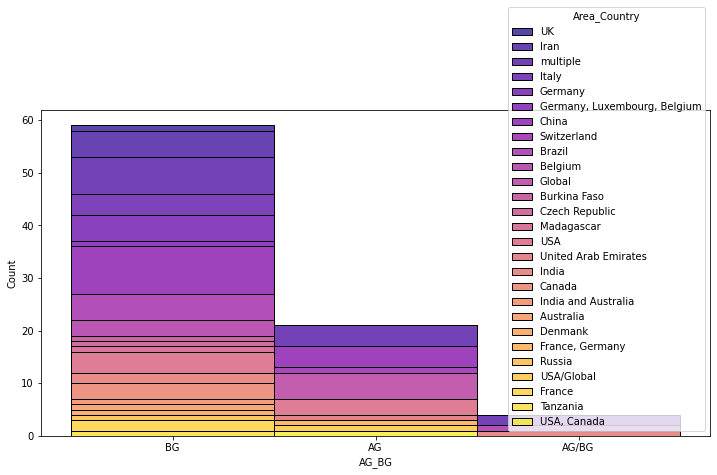

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(x="AG_BG", data=docBiblio, hue="Area_Country",multiple="stack",
             palette="plasma",bins = 3, ax=ax)


plt.savefig('/content/drive/My Drive/prelims/figures/byAGBG-Area.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/byAGBG-Area.svg')

plt.show()

In [ ]:
#docBiblio.groupby('RS_type').count()

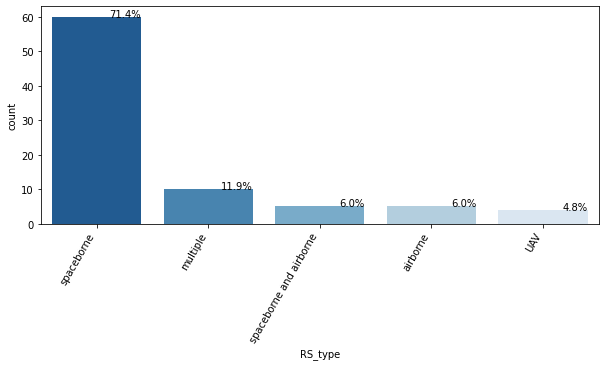

In [ ]:
total = float(len(docBiblio))

fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x='RS_type', data=docBiblio,  palette="Blues_r",order = docBiblio['RS_type'].value_counts().index, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right')


plt.savefig('/content/drive/My Drive/prelims/figures/byRS.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/byRS.svg')
plt.show()

In [ ]:
docBiblio.groupby('Publication Year').count()

,Author,Title,type,Spectral,RS_type,AG_BG,Method,Area_Country,Latitude,Longitude,Publication Title,Url,Abstract Note
Publication Year,,,,,,,,,,,,,
2012,2,2,2,1,2,2,1,2,1,1,2,2,2
2013,5,5,5,2,5,5,5,5,1,1,5,5,5
2014,3,3,3,3,3,3,3,3,1,1,3,3,3
2015,5,5,5,5,5,5,4,5,3,3,5,5,5
2016,12,12,12,11,12,12,11,12,9,9,12,12,12
2017,7,7,7,7,7,7,7,7,4,4,7,7,7
2018,10,10,10,10,10,10,10,10,8,8,10,10,10
2019,12,12,12,9,12,12,12,12,8,8,12,12,12
2020,10,10,10,9,10,10,10,10,9,9,10,10,10


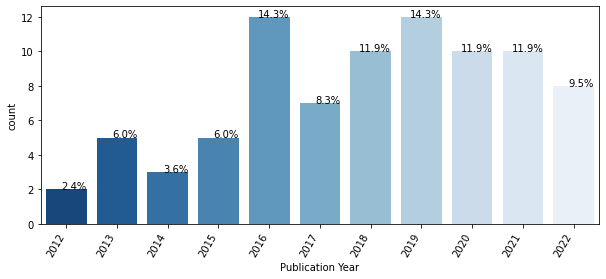

In [ ]:
total = float(len(docBiblio))

fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x='Publication Year', data=docBiblio,  palette="Blues_r", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right')


plt.savefig('/content/drive/My Drive/prelims/figures/byPubYear.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/byPubYear.svg')

plt.show()

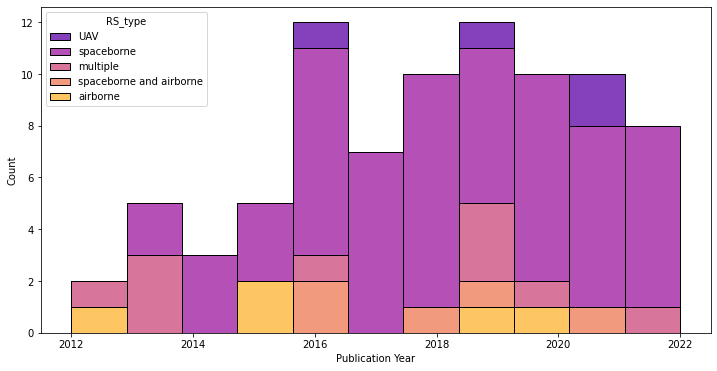

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(x="Publication Year", data=docBiblio, hue="RS_type",multiple="stack",
             palette="plasma",bins = 11, ax=ax)

plt.savefig('/content/drive/My Drive/prelims/figures/byRS-PubYear.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/byRS-PubYear.svg')

plt.show()


In [ ]:
#docBiblio.groupby('Publication Title').count()

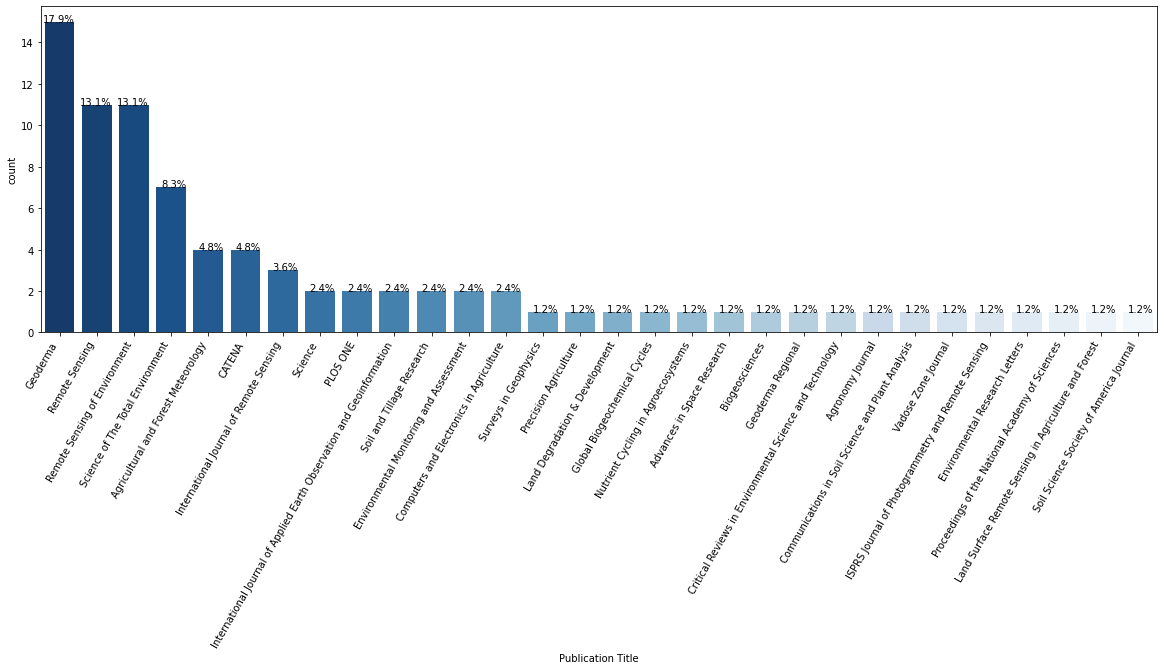

In [ ]:
total = float(len(docBiblio))

fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(x='Publication Title', data=docBiblio,  palette="Blues_r", order = docBiblio['Publication Title'].value_counts().index,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right')

plt.savefig('/content/drive/My Drive/prelims/figures/byPub.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/byPub.svg')

plt.show()

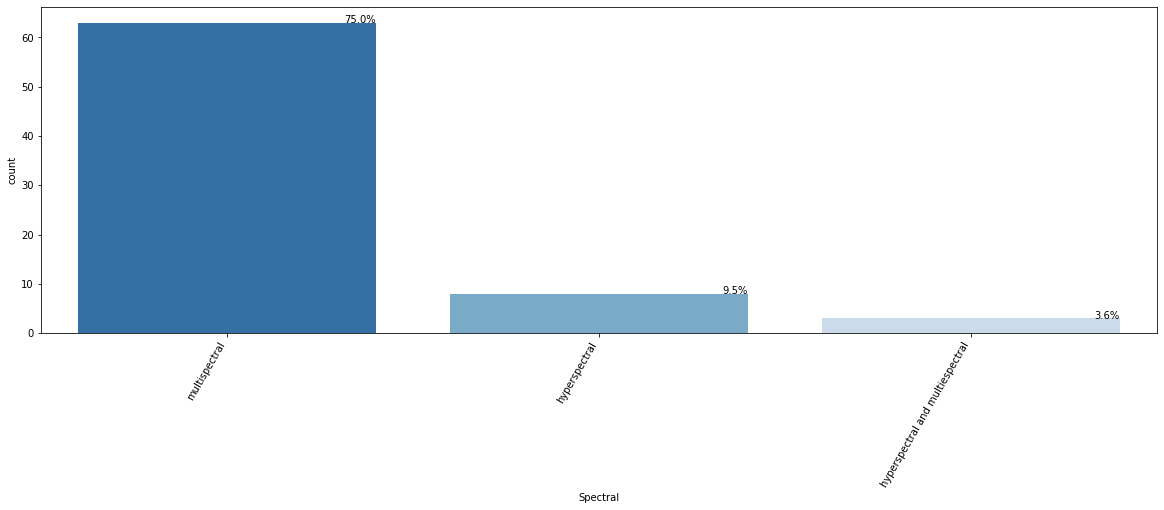

In [ ]:
total = float(len(docBiblio))

fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(x='Spectral', data=docBiblio,  palette="Blues_r", order = docBiblio['Spectral'].value_counts().index,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right')

plt.savefig('/content/drive/My Drive/prelims/figures/bySpectra.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/bySpectra.svg')

plt.show()

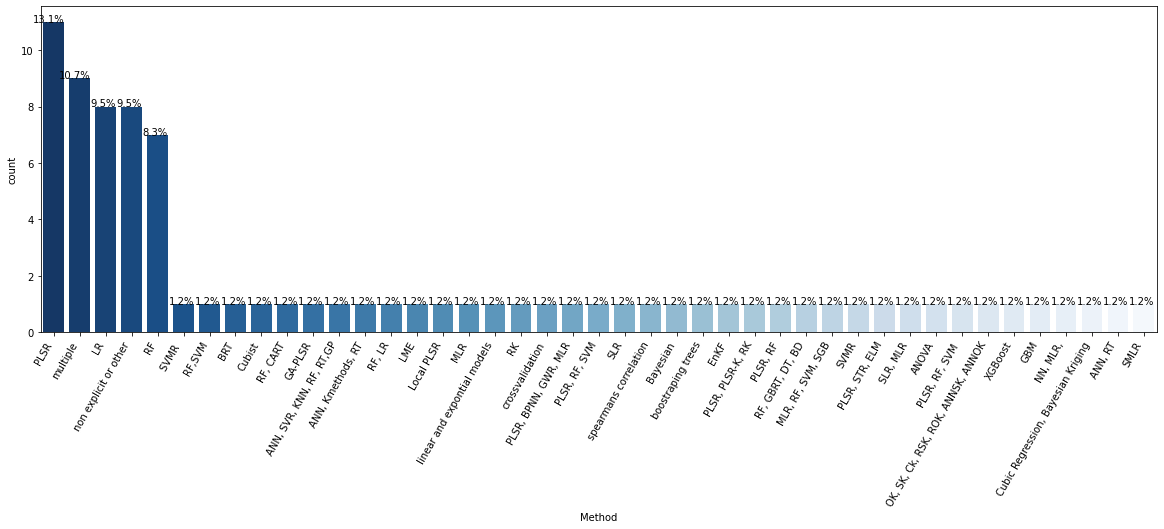

In [ ]:
total = float(len(docBiblio))

fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(x='Method', data=docBiblio,  palette="Blues_r", order = docBiblio['Method'].value_counts().index,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right')

plt.savefig('/content/drive/My Drive/prelims/figures/byMethod.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/byMethod.svg')

plt.show()

In [ ]:
location=docBiblio.groupby(['AG_BG','Latitude','Longitude','Area_Country']).size().reset_index(name='count').sort_values(by='count',ascending=False)

In [ ]:
color = {
  "BG": "#CFC98D",
  "AG/BG" : "#D4E6DE",
  "AG": "#76D7C4",
  }
location['color']= location['AG_BG'].map(color)

In [ ]:
location['size']=location['count'].apply(lambda count:24 if count>=9 else
                                         20 if count>=5 and count<9 else
                                         18 if count>=4 and count<5 else
                                         16 if count>=3 and count<4 else
                                         14 if count>=2 and count<3 else
                                         12 if count>=1 and count<2 else
                                         10 if count>=0 and count<1 else
                                         0.1)

In [ ]:
Lon = list(location["Longitude"])
Lat=list(location["Latitude"])
n=list(location["count"])
loc = list(location['Area_Country'])
c = list(location['AG_BG'])
loc_n_c = list(zip(Lon, Lat,n,c))
rest= list(zip(loc, loc_n_c))

In [ ]:
rest

[('China', (105.0, 35.0, 8, 'BG')),
 ('Iran', (53.0, 32.0, 5, 'BG')),
 ('Germany', (10.5, 51.5, 5, 'BG')),
 ('Brazil', (-55.0, -10.0, 5, 'BG')),
 ('Italy', (12.833333, 42.833333, 4, 'BG')),
 ('China', (105.0, 35.0, 4, 'AG')),
 ('USA', (-98.5795, 39.828175, 4, 'BG')),
 ('USA', (-98.5795, 39.828175, 3, 'AG')),
 ('Canada', (-96.0, 60.0, 3, 'BG')),
 ('Belgium', (4.0, 50.83333, 3, 'BG')),
 ('India', (77.0, 20.0, 2, 'BG')),
 ('France', (2.0, 46.0, 2, 'BG')),
 ('Denmank', (10.0, 56.0, 1, 'BG')),
 ('UK', (-4.0, 54.0, 1, 'BG')),
 ('Czech Republic', (15.0, 49.75, 1, 'BG')),
 ('Switzerland', (31.5, -26.5, 1, 'AG')),
 ('United Arab Emirates', (54.0, 24.0, 1, 'AG')),
 ('Burkina Faso', (-2.0, 13.0, 1, 'BG')),
 ('Tanzania', (35.0, -6.0, 1, 'BG')),
 ('Madagascar', (47.0, -20.0, 1, 'BG')),
 ('Australia ', (135.0, -25.0, 1, 'BG')),
 ('India', (77.0, 20.0, 1, 'AG/BG')),
 ('Brazil', (-55.0, -10.0, 1, 'AG/BG')),
 ('Russia', (100.0, 60.0, 1, 'BG'))]

In [46]:
data = [('China', [105.0, 35.0, 8, 'BG']),
 ('USA', [-98.5795, 39.828175, 3, 'AG']),
 ('Germany', [10.5, 51.5, 5, 'BG']),
 ('Brazil', [-55.0, -10.0, 5, 'BG']),
 ('USA', [-90.5795, 39.828175, 4, 'BG']),
 ('Iran', [53.0, 32.0, 5, 'BG']),
 ('China', [98.0, 35.0, 4, 'AG']),
 ('Italy', [12.833333, 42.833333, 4, 'BG']),
 ('Canada', [-96.0, 60.0, 3, 'BG']),
 ('Belgium', [4.0, 50.83333, 3, 'BG']),
 ('India', [77.0, 20.0, 2, 'BG']),
 ('France', [2.0, 46.0, 2, 'BG']),
 ('Denmark', [10.0, 56.0, 1, 'BG']),
 ('UK', [-4.0, 54.0, 1, 'BG']),
 ('Czech Reublic', [15.0, 49.75, 1, 'BG']),
 ('Switzerland', [ 8.135832,46.942896, 1, 'AG']),
 ('Burkina Faso', [-2.0, 13.0, 1, 'BG']),
 ('Tanzania', [35.0, -6.0, 1, 'BG']),
 ('Madagascar', [47.0, -20.0, 1, 'BG']),
 ('Australia', [135.0, -25.0, 1, 'BG']),
 ('India', [70.0, 20.0, 1, 'AG/BG']),
 ('Brazil', [-48.0, -10.0, 1, 'AG/BG']),
 ('UAE', [54.0, 24.0, 1, 'AG']),
 ('Russia', [100.0, 60.0, 1, 'BG'])]

In [47]:
#interactive map with AG_BG plotted as bars over each Country. 
#the result gets stored on the google colab folder, a static view is depicted below.
#to see the interactive one, open the html file provided
c = (
    Map3D()
    .add_schema(
        maptype="world",
        itemstyle_opts=opts.ItemStyleOpts(
            color="rgb(5,101,123)",
            opacity=0.5,
            border_width=0.3,
            border_color="rgb(62,215,213)",
        ),
        map3d_label=opts.Map3DLabelOpts(
            is_show=False,
            formatter=JsCode("function(data){data.value[2];}"),
        ),
        emphasis_label_opts=opts.LabelOpts(
            is_show=True,
            color="#76D7C4",
            font_size=8,
            background_color="rgba(0,23,11,0)",
        ),
        light_opts=opts.Map3DLightOpts(
            main_color="#76D7C4",
            main_intensity=1.2,
            main_shadow_quality="high",
            is_main_shadow=True,
            main_beta=10,
            ambient_intensity=0.6,
        ),
    )
    .add(
        series_name="AB-BG publications by Country",
        data_pair=data,
        type_=ChartType.BAR3D,
        
        bar_size=1.5,
        shading="lambert",
        label_opts=opts.LabelOpts(
            is_show=False,
            formatter=JsCode("function(data){return data.name + ' ' + data.value[2];}"),
        ),
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="Review Map"))
    .render("/content/drive/My Drive/prelims/figures/map3d.html")
)

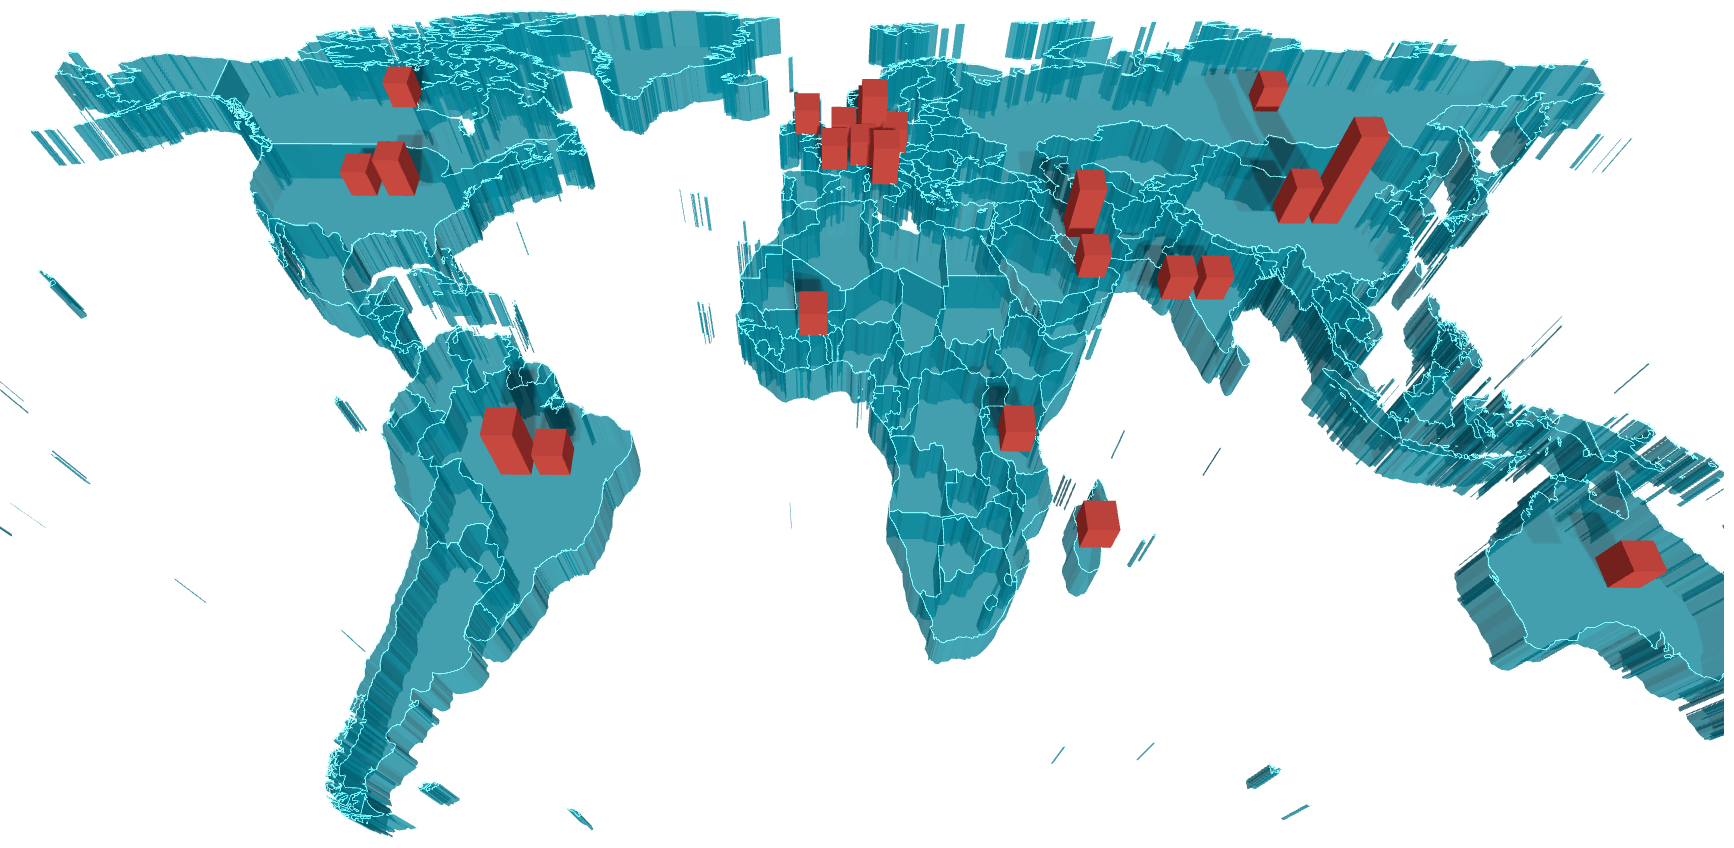

In [48]:
#interactive funnel, based on the tags proposed on the PRISMA 2020 protocol 

fig = go.Figure(go.Funnel(
    y = ["Identification", "After duplicates, JCR Q1-Q3 and quality", "Screening", "+bibliography", "Included"],
    x = [326, 186, 56, 28,84],
    textposition = "inside",
    textinfo = "value+percent initial",
    
    opacity = 0.70, marker = {"color": ["#062F5B", "#084A76", "#41A5B2", "#5CB8BD", "#82CDCF", "#48A448"],
    "line": {"width": [0, 0, 0, 0, 0, 0], "color": ["#A9E0DE", "#A9E0DE", "#A9E0DE", "#A9E0DE", "#A9E0DE"]}},
    connector = {"line": {"color": "#82CDCF", "dash": "solid","width": 0}})
    )
fig.update_layout(
    showlegend=False,
    font={'size': 12},
    title={'text': '<b>Systematic Review, PRISMA flow </b>', 'font': {'size': 15}}
)

fig.show()
fig.write_image("/content/drive/My Drive/prelims/figures/funnel.svg")

## Language processing to identify the most common words

### proof of concept over data from abstracts, already extracted from the bibliography metadata

In [49]:
docBiblio.columns

Index(['Publication Year', 'Author', 'Title', 'type', 'Spectral', 'RS_type',
       'AG_BG', 'Method', 'Area_Country', 'Latitude', 'Longitude',
       'Publication Title', 'Url', 'Abstract Note'],
      dtype='object')

In [50]:
droped= [3,4, 5, 6, 7, 8,9, 10, 12]
docBiblio.drop(docBiblio.columns[droped],axis=1, inplace=True)

In [51]:
docBiblio.head(3)

,Publication Year,Author,Title,Publication Title,Abstract Note
0,2016,"Aldana-Jague, Emilien; Heckrath, Goswin; Macdo...",UAS-based soil carbon mapping using VIS-NIR (4...,Geoderma,Traditional methods to assess the soil organic...
1,2017,"Amirian Chakan, A.; Taghizadeh-Mehrjardi, R.; ...",Spatial 3D distribution of soil organic carbon...,Environmental Monitoring and Assessment,Soil organic carbon (SOC) has been assessed in...
2,2019,"Angelopoulou, Theodora; Tziolas, Nikolaos; Bal...",Remote Sensing Techniques for Soil Organic Car...,Remote Sensing,"Towards the need for sustainable development, ..."


In [52]:
#personal list with most common (and not informative) words in scientific literature
literature_words= ["nan",
 "catena",
 "author",
 'al',
 'et',
 'the','environment',
 'a','b','d','e','f','g','h','i','j',
 'k','l','m','n','o','p','q','r','s','t',
 'u','v','w','x','y','z',
 'data','studies','ieee', 'sel', 
'using','study','area','used','doi','http',
'based','fig','in','index','cid','use','eld'
,'also', 'this', 'table','area', 'well','org', 'within','keyword','geoderma', 
'nm','science','society','journal','int','appl','obs','international',
'elsevier','all','reserved','geoinf', 'cm', 'ob', 'review', 
'trans', 'geosci', 'sens’, ‘ieee',  'geosci','sciencedirect','xiao',
'journal', 'geophysical', 'research', 'biogeosciences','isprs', 'photogramm', 
'applied', 'earth', 'observation', 'geoinformation',
'reader', 'referred', 'web', 'version','referred', 'article', 
'arti', 'cial', 'neural', 'network','proc', 'natl', 'acad', 'sci',
'legend',  'plos','one', 'doi', 'geoscience','environ',
'pone','sci', 'total', 'environ', 'scitotenv','sens', 
'for','peer','history','photogrammetry','mote','comput','eng',
'received','geoscience', 'symposium','core', 'team',
'sci', 'am', 'crossref’,’www', 'elsevier', 'com',
]

In [53]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(literature_words)
stop_words = set(stop_words)

In [55]:

def wordData(text):

    cleaning= re.sub("[^a-zA-Z]", " ", str(text).lower())
    words = cleaning.split()
    cleaned_words = []
    lemmatizer = WordNetLemmatizer()
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # lemmatizer
    lemma_words = []
    for word in cleaned_words:
        word = lemmatizer.lemmatize(word)   
        lemma_words.append(word)
    
    # converting list back to string
    return " ".join(lemma_words)

In [56]:
tester = "tillage, removal of crop residue, nan, area, http study and overgrazing Remo in geoinformation are the main causes of decreased SOM (Bot and Benites 2005)"
wordData(tester)

'tillage removal crop residue overgrazing remo main cause decreased som bot benites'

In [57]:
docBiblio['data_abstract'] = docBiblio['Abstract Note'].apply(wordData)

docBiblio.head(3)

,Publication Year,Author,Title,Publication Title,Abstract Note,data_abstract
0,2016,"Aldana-Jague, Emilien; Heckrath, Goswin; Macdo...",UAS-based soil carbon mapping using VIS-NIR (4...,Geoderma,Traditional methods to assess the soil organic...,traditional method ass soil organic carbon soc...
1,2017,"Amirian Chakan, A.; Taghizadeh-Mehrjardi, R.; ...",Spatial 3D distribution of soil organic carbon...,Environmental Monitoring and Assessment,Soil organic carbon (SOC) has been assessed in...,soil organic carbon soc assessed three dimensi...
2,2019,"Angelopoulou, Theodora; Tziolas, Nikolaos; Bal...",Remote Sensing Techniques for Soil Organic Car...,Remote Sensing,"Towards the need for sustainable development, ...",towards need sustainable development remote se...


In [58]:
Counter(' '.join(docBiblio['data_abstract']).split()).most_common(15)

[('soil', 442),
 ('soc', 295),
 ('model', 192),
 ('carbon', 182),
 ('prediction', 99),
 ('scale', 93),
 ('spectral', 91),
 ('spatial', 90),
 ('c', 89),
 ('remote', 88),
 ('sensing', 87),
 ('content', 85),
 ('result', 82),
 ('agricultural', 80),
 ('sif', 80)]

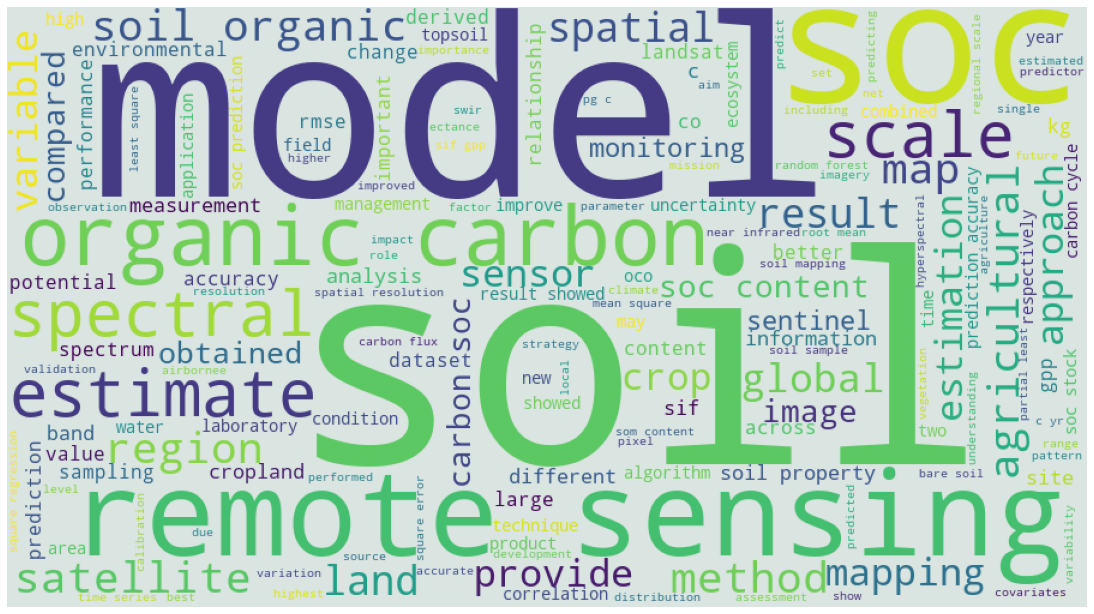

In [59]:
words_inText = ''

for sents in docBiblio['data_abstract']:
  tokens = sents.split()
  words_inText += ' '.join(tokens) + ' '

wordcloud = WordCloud(width = 900, height = 500,
                       background_color = '#DAE4E0',
                       min_font_size = 10).generate(words_inText)

plt.figure(figsize = (15, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  

plt.savefig('/content/drive/My Drive/prelims/figures/wordCloud_abtracts.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/wordCloud_abtracts.svg')

plt.show()

## Extracting data from PDFs, text mining and topic modeling 

In [60]:
folder= '/content/drive/My Drive/prelims/papers'

def get_files(folder):
    import os
    os.chdir(folder)
    files = os.listdir()
    files = [x for x in files if x.endswith(".pdf")]
    return files 
files = get_files(folder) 


In [61]:
with open('/content/drive/My Drive/prelims/papers/corpus/corpus.txt', 'w') as output:
  for file in files: 
    text1=extract_text(file, 'rb')
    #print(text)
    output.write(text1)


In [65]:
files_pdf = pd.read_csv('/content/drive/My Drive/prelims/papers/corpus/corpus.csv')
files_pdf.columns=['first']
files_pdf['data'] = files_pdf['first'].apply(wordData)

In [66]:
Counter(' '.join(files_pdf['data']).split()).most_common(15)

[('soil', 12158),
 ('soc', 5171),
 ('c', 4975),
 ('model', 4139),
 ('carbon', 3469),
 ('remote', 3297),
 ('spectral', 2497),
 ('content', 2014),
 ('sensing', 2010),
 ('value', 1989),
 ('spatial', 1962),
 ('organic', 1959),
 ('image', 1937),
 ('land', 1828),
 ('crop', 1794)]

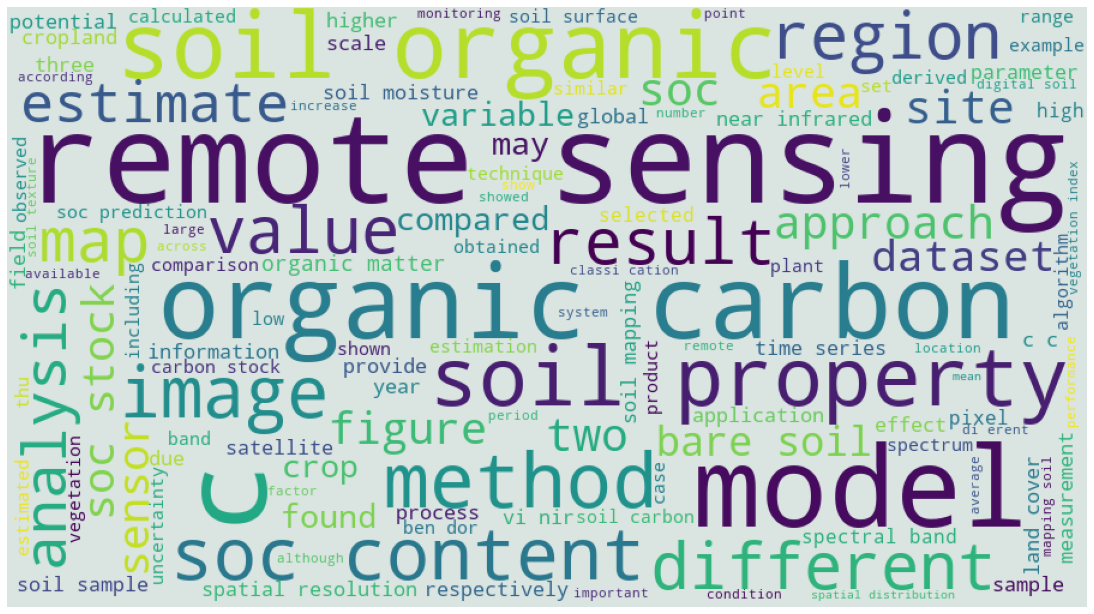

In [68]:

words_inText = ''

for arg in files_pdf['data']:
  tokens = arg.split()
  words_inText += ' '.join(tokens) + ' '

wordcloud = WordCloud(width = 900, height = 500,
                       background_color = '#DAE4E0',
                       min_font_size = 10).generate(words_inText)

plt.figure(figsize = (15, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  


plt.savefig('/content/drive/My Drive/prelims/figures/wordCloud_corpus.png', dpi=300)
plt.savefig('/content/drive/My Drive/prelims/figures/wordCloud_corpus.svg')

plt.show()

In [69]:
train_text=list(files_pdf['data'])
with open(r'/content/drive/My Drive/prelims/papers/corpus/train_text.txt', 'w') as fp:
    for item in train_text:
        fp.write("%s\n" % item)
    print('Done')

train_text=open('/content/drive/My Drive/prelims/papers/corpus/train_text.txt').read()


Done


In [70]:
model_cbow=fasttext.train_unsupervised('/content/drive/My Drive/prelims/papers/corpus/train_text.txt', 
                                  model='cbow', maxn=0)

In [71]:
model_cbow.save_model("/content/drive/My Drive/prelims/papers/model/fasttext_model_cbow.bin")

In [72]:
model_cbow.get_nearest_neighbors('regression', 15)

[(0.96526700258255, 'kriging'),
 (0.9479962587356567, 'multivariate'),
 (0.9414365291595459, 'linear'),
 (0.9407652020454407, 'pls'),
 (0.9307955503463745, 'svm'),
 (0.9263427257537842, 'procedure'),
 (0.919074535369873, 'mlr'),
 (0.9143409729003906, 'multiple'),
 (0.9138392210006714, 'rk'),
 (0.9136872291564941, 'partial'),
 (0.9132122993469238, 'vector'),
 (0.9127108454704285, 'boosted'),
 (0.9110872745513916, 'least'),
 (0.9092376232147217, 'plsr'),
 (0.9070449471473694, 'ordinary')]

In [73]:
model_cbow.get_nearest_neighbors('carbon', 15)

[(0.9407082200050354, 'pool'),
 (0.9316418170928955, 'dioxide'),
 (0.9258971214294434, 'nitrogen'),
 (0.920678973197937, 'sequestration'),
 (0.8951835036277771, 'microbial'),
 (0.8917312622070312, 'balance'),
 (0.8901858925819397, 'dynamic'),
 (0.8843247890472412, 'energy'),
 (0.8734975457191467, 'storage'),
 (0.8720536231994629, 'organic'),
 (0.8675629496574402, 'uxes'),
 (0.8658237457275391, 'role'),
 (0.8629862070083618, 'sink'),
 (0.8620747327804565, 'terrestrial'),
 (0.8609004616737366, 'exchange')]

In [74]:
model_cbow.get_nearest_neighbors('satellite', 15)

[(0.9760414958000183, 'imagery'),
 (0.9583821892738342, 'multispectral'),
 (0.9571194648742676, 'platform'),
 (0.9496245384216309, 'lidar'),
 (0.9483696818351746, 'sar'),
 (0.9476679563522339, 'mission'),
 (0.9471981525421143, 'spaceborne'),
 (0.94455885887146, 'multi'),
 (0.9406765103340149, 'optical'),
 (0.9344184994697571, 'operational'),
 (0.9340033531188965, 'radar'),
 (0.933764636516571, 'etm'),
 (0.9333580136299133, 'landsat'),
 (0.9303679466247559, 'tm'),
 (0.9297026991844177, 'sensor')]

In [75]:
model_cbow.get_nearest_neighbors('sensing',15)

[(0.9767551422119141, 'remote'),
 (0.9179766774177551, 'optical'),
 (0.8883281946182251, 'lidar'),
 (0.8791972398757935, 'application'),
 (0.8670130968093872, 'mission'),
 (0.8669970035552979, 'space'),
 (0.8596273064613342, 'monitoring'),
 (0.8512585163116455, 'crossref'),
 (0.8435724377632141, 'spaceborne'),
 (0.8408235311508179, 'satellite'),
 (0.8406826853752136, 'forthcoming'),
 (0.8404642343521118, 'operational'),
 (0.8377923965454102, 'enmap'),
 (0.8300451636314392, 'potential'),
 (0.8243589401245117, 'proximal')]

In [76]:
model_cbow.get_nearest_neighbors('belowground',15)

[(0.9969385266304016, 'stem'),
 (0.9956406950950623, 'autotrophic'),
 (0.9953792095184326, 'allocated'),
 (0.9947656393051147, 'ydw'),
 (0.9944774508476257, 'seedling'),
 (0.9942813515663147, 'allocation'),
 (0.9941884279251099, 'hdw'),
 (0.9936944246292114, 'mary'),
 (0.9935420751571655, 'permanent'),
 (0.9934442043304443, 'nationwide'),
 (0.9934197068214417, 'conservative'),
 (0.9932712316513062, 'terl'),
 (0.9932382106781006, 'atriplex'),
 (0.9931176900863647, 'harvestable'),
 (0.9931092858314514, 'total')]

In [77]:
words_tok=nltk.word_tokenize(train_text)
stop_words_2=stopwords.words('english')
stop_words_2.extend(literature_words)


In [78]:
word_list = []
for words in words_tok:
  if words not in stop_words_2:
    word_list.append(words)
    


In [79]:
dict= corpora.Dictionary([word_list])
corpus = [dict.doc2bow(wd) for wd in [word_list]]

In [83]:
#repeated for 2, and 3 
n = 2
ngrams_ = ngrams(word_list, n)
freq_ = nltk.FreqDist(ngrams_)
freq_.most_common(10)# increase the number and clean 

[(('remote', 'sensing'), 1904),
 (('organic', 'carbon'), 1303),
 (('soil', 'organic'), 1273),
 (('soil', 'property'), 1005),
 (('soc', 'content'), 775),
 (('soc', 'stock'), 476),
 (('bare', 'soil'), 469),
 (('organic', 'matter'), 447),
 (('spatial', 'resolution'), 443),
 (('soil', 'moisture'), 433)]

In [84]:
ngram = ['root mean square error', 'partial least square regression', 
         'soil organic carbon stock','mapping soil organic carbon', 
         'soil organic carbon', 'digital soil mapping', 
         'soil organic matter','visible near infrarred', 
         'remote sensing', 'organic carbon','soil property', 
         'bare soil', 'spatial resolution' ]
frequency = [133,129,106, 94,985,257,238,185, 1904, 1303, 1005,469,443 ]
fig= px.scatter(y=ngram, x=frequency)
fig.update_traces(marker_size=10, marker_opacity= 0.6,marker_color="#2D8287",
                  textfont_size= 2)
fig.update_yaxes(tickfont_size=8)
fig.update_xaxes(tickfont_size=8)
fig.update_layout(
    showlegend=False,
    font={'size': 12},
    title={'text': '<b>n-grams 4-2 and frequency </b>', 'font': {'size': 15}}
)
fig.show()
fig.write_html('/content/drive/My Drive/prelims/figures/ngrams.html')
fig.write_image("/content/drive/My Drive/prelims/figures/ngrams.svg")

In [85]:
%%capture
#with more time a more curated corpus will be organized with one entry per file, using the keywords as main topics
#for now, this is an example on how to perform a LDA analysis to find the emergin topic.

LDA_model= gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict,
                                           random_state=123,
                                           num_topics=2,
                                           passes=20,
                                           iterations=5,
                                           alpha='symmetric',
                                           per_word_topics=True)

In [86]:
LDA_model.print_topics()

[(0,
  '0.022*"soil" + 0.012*"soc" + 0.010*"c" + 0.009*"model" + 0.007*"carbon" + 0.007*"remote" + 0.005*"spectral" + 0.004*"sensing" + 0.004*"image" + 0.004*"content"'),
 (1,
  '0.028*"soil" + 0.010*"c" + 0.010*"soc" + 0.008*"model" + 0.007*"carbon" + 0.007*"remote" + 0.006*"spectral" + 0.005*"organic" + 0.005*"spatial" + 0.004*"value"')]

In [87]:
pyLDAvis.enable_notebook()
viz=pyLDAvis.gensim_models.prepare(LDA_model, corpus, dictionary=LDA_model.id2word)
viz

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.002667  0.0       1        1  58.672076
0     -0.002667  0.0       2        1  41.327924, topic_info=          Term         Freq        Total Category  logprob  loglift
20723      soc  4838.000000  4838.000000  Default  30.0000  30.0000
14341    model  3884.000000  3884.000000  Default  29.0000  29.0000
8001    forest  1174.000000  1174.000000  Default  28.0000  28.0000
3239    carbon  3276.000000  3276.000000  Default  27.0000  27.0000
21694  surface  1172.000000  1172.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
19680    scale   524.456388  1369.577308   Topic2  -5.8879  -0.0763
15977  organic   626.848623  1907.851815   Topic2  -5.7095  -0.2294
1744      band   578.544965  1716.380126   Topic2  -5.7897  -0.2038
19534   sample   506.051188  1454.145478   Topic2  -5.9236  -0.1719
13997   method   488.951848  1381.988839   Topic2  -5.9580  -0.1554

[202 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
147        1  0.453299  accounted
147        2  0.550434  accounted
158        1  0.658629   accuracy
158        2  0.341865   accuracy
266        1  0.725909   addition
...      ...       ...        ...
24016      2  0.557836         vv
24083      1  0.488704       wang
24083      2  0.511976       wang
24927      1  0.732637         zi
24927      2  0.274739         zi

[296 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [88]:

pyLDAvis.save_html(viz,'/content/drive/My Drive/prelims/figures/lda.html')



---



---

